## Pre-requisites

Package installations (re-run runtime after executing code cell)

In [ ]:
!pip install top2vec
!pip install git+https://github.com/openai/whisper.git
!pip install resampy
!apt-get install portaudio19-dev
!pip install pyaudio

Imports

In [1]:
import os
import sys
import wave
import librosa
import shutil
import random
import numba
import resampy
import pyaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers import (Activation, AveragePooling1D, Conv1D, Dense, Dropout, Embedding, Flatten, Input, LSTM, MaxPooling1D)
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TPU Access

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.29.162.58:8470']


Prepare project content

In [4]:
# Copy data sample from RAVDESS
try:
  os.mkdir('libs')
  os.mkdir('data')
  os.mkdir('data/RAVDESS')
  os.mkdir('data/SalsaSound')
  os.mkdir('data/MyInput')
  os.mkdir('models')
except FileExistsError:
  pass
except Exception as e:
  print("An error occurred while creating the 'data', 'RAVDESS', or 'models' directory:", e)
for i in range(1, 4):
  try:
    shutil.copytree('drive/MyDrive/SA-Speech/data/RAVDESS/Actor_0{0}'.format(i), 'data/RAVDESS/Actor_0{0}'.format(i))
  except Exception as e:
    print('Output directory data/RAVDESS/Actor_0{0}'.format(i), 'exists already')
try:
  shutil.copy('drive/MyDrive/SA-Speech/models/Emotion_Voice_Detection_Model.h5', 'models/Emotion_Voice_Detection_Model.h5')
except FileExistsError:
  pass
except Exception as e:
  print("An error occurred while copying the model files:", e)
try:
  shutil.copy('drive/MyDrive/SA-Speech/data/SalsaSound/commentary_short.wav', 'data/SalsaSound/commentary_short.wav')
except FileExistsError:
  pass
except Exception as e:
  print("An error occurred while copying the SalsaSound data files:", e)

# Gathering external repository libraries
!git clone https://github.com/qasimkamran/SA-Speech.git libs/SA-Speech 

Cloning into 'libs/SA-Speech'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 105 (delta 30), reused 63 (delta 15), pack-reused 22
Receiving objects: 100% (105/105), 76.72 MiB | 47.64 MiB/s, done.
Resolving deltas: 100% (35/35), done.


## Read in audio files
**Run this code cell if you want to test on the given RAVDESS dataset**

In [5]:
ravdess_dir = 'data/RAVDESS'

# Get a list of all the directories in the RAVDESS directory
actor_dirs = [os.path.join(ravdess_dir, d) for d in os.listdir(ravdess_dir) if os.path.isdir(os.path.join(ravdess_dir, d))]

audio_data = []

audio_names = []

# Loop through each actor directory and load a random audio file
categories_fulfilled = []
while len(categories_fulfilled) < 10: # Fulfill one of each 10 categories
  for actor_dir in actor_dirs:
    audio_files = [f for f in os.listdir(actor_dir) if f.endswith('.wav')]
    if audio_files:
      sex_str = ''
      emotion_id = '01'
      while emotion_id in ['01', '07', '08']: # Filter out certain emotions to be consistent with original
        audio_file = random.choice(audio_files)
        split_name = audio_file.split('-')
        emotion_id = split_name[2]
        sex_id = split_name[6]
        sex_id = sex_id.split('.')[0] # Last bit in filename unsplit from file extension
        sex_str = 'F' if int(sex_id) % 2 == 0 else 'M'
      category = (sex_str, emotion_id)
      if category not in categories_fulfilled:
        categories_fulfilled.append(category)
      else:
        continue
      audio_path = os.path.join(actor_dir, audio_file)
      audio, sample_rate = librosa.load(audio_path, res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
      audio_names.append(audio_file)
      audio_data.append([audio, sample_rate])
      print(f"Loaded audio file {audio_path} with shape {audio.shape} and sampling rate {sample_rate}")
    else:
      print(f"No audio files found in directory {actor_dir}")

print('Number of audio files loaded:', len(audio_names))

Loaded audio file data/RAVDESS/Actor_02/03-01-02-02-01-02-02.wav with shape (110250,) and sampling rate 44100
Loaded audio file data/RAVDESS/Actor_01/03-01-04-02-02-02-01.wav with shape (110250,) and sampling rate 44100
Loaded audio file data/RAVDESS/Actor_03/03-01-03-02-01-01-03.wav with shape (110250,) and sampling rate 44100
Loaded audio file data/RAVDESS/Actor_02/03-01-06-02-02-01-02.wav with shape (110250,) and sampling rate 44100
Loaded audio file data/RAVDESS/Actor_03/03-01-02-02-02-01-03.wav with shape (110250,) and sampling rate 44100
Loaded audio file data/RAVDESS/Actor_02/03-01-05-02-02-02-02.wav with shape (110250,) and sampling rate 44100
Loaded audio file data/RAVDESS/Actor_03/03-01-05-02-02-02-03.wav with shape (110250,) and sampling rate 44100
Loaded audio file data/RAVDESS/Actor_02/03-01-03-01-01-02-02.wav with shape (110250,) and sampling rate 44100
Loaded audio file data/RAVDESS/Actor_02/03-01-04-02-01-02-02.wav with shape (110250,) and sampling rate 44100
Loaded aud

**Run these code cells if you want to prepare and test on input voice data**

In [6]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

record()

<IPython.core.display.Javascript object>

Visualise each audio clip with name to manually label emotion

In [8]:
for i, (audio, sample_rate) in enumerate(audio_data):
  print(audio_names[i])
  display(Audio(audio, rate=sample_rate))
  print()

Output hidden; open in https://colab.research.google.com to view.

Visualise them for validating reads

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(21, 10))
axs = axs.flatten()
# Loop through each audio file and plot it in a separate subplot
for i, (audio, sample_rate) in enumerate(audio_data):
  librosa.display.waveshow(audio, sr=sample_rate, ax=axs[i])
  axs[i].set(title=f'Audio {i+1}')
  display(Audio(audio, rate=sample_rate))
  print()
# Display the figure
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Representing audio waves in spectrogram

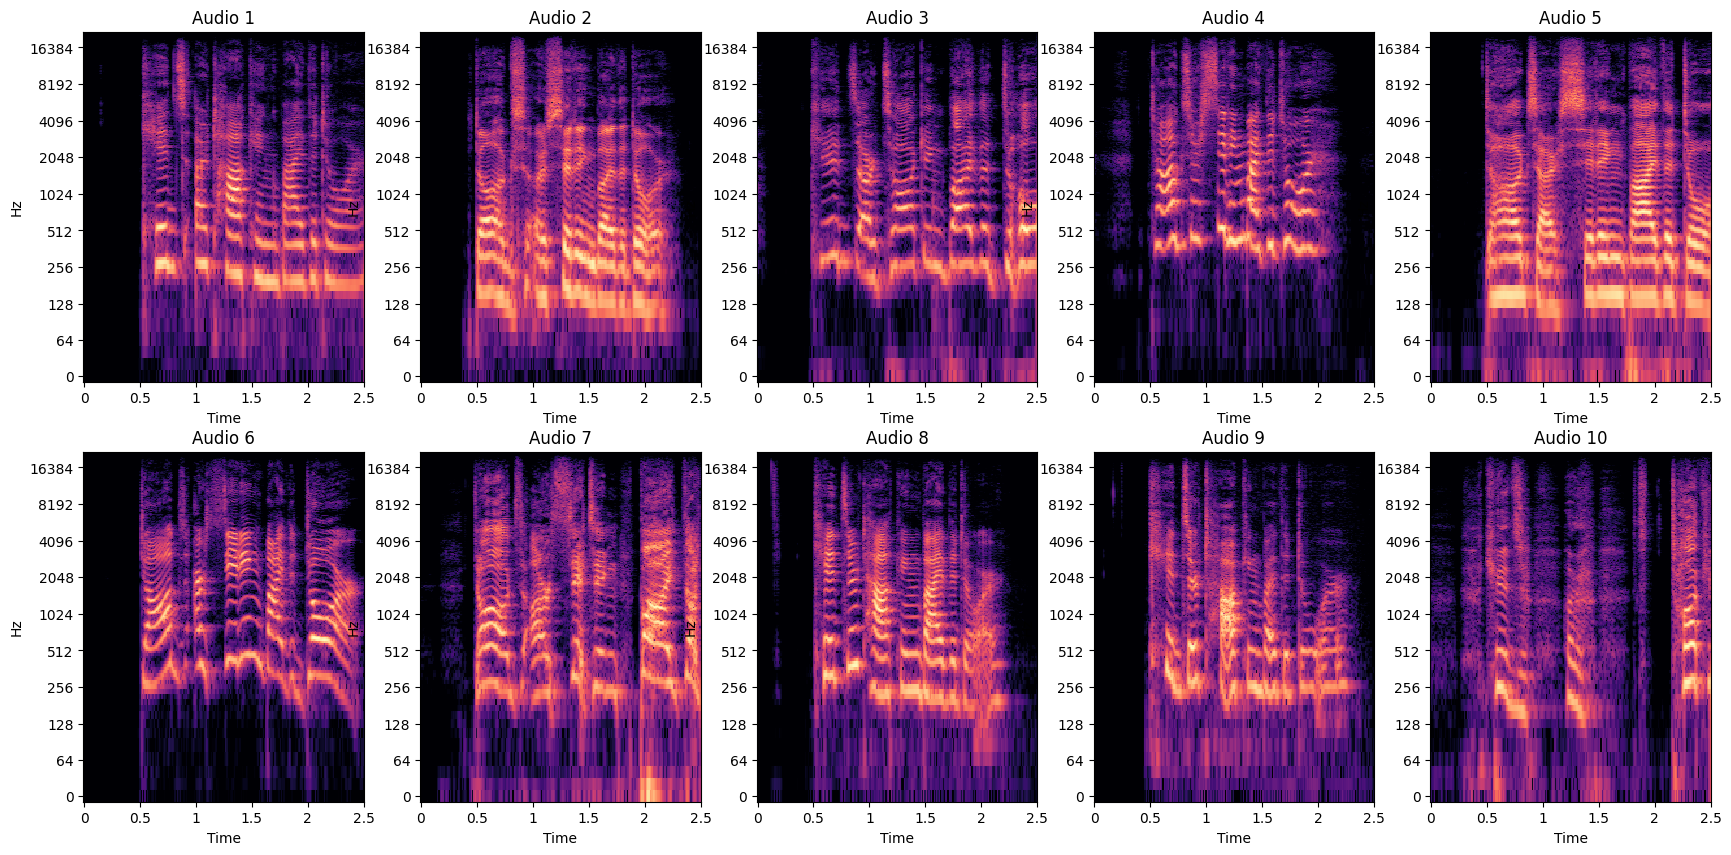

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(21, 10))
axs = axs.flatten()
# Loop through each audio file and plot it in a separate subplot
for i, (audio, sample_rate) in enumerate(audio_data):
  spectrogram = np.abs(librosa.stft(audio))
  librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=sample_rate, ax=axs[i], y_axis='log', x_axis='time')
  axs[i].set(title=f'Audio {i+1}')
# Display the figure
plt.show()

## Preparing labels for test data

Emotion represented by 3rd bit in filename:
1. neutral 
2. **calm**
3. **happy**
4. **sad**
5. **angry**
6. **fearful**
7. disgust
8. surprised

Intensity represented by 4th bit in filename: 1, 2, 3

Actor sex is represented by 7th bit in filename: M (Odd number), F (Even number)

In [11]:
audio_label_info = []

for name in audio_names:
  split_name = name.split('-')
  emotion_id = split_name[2]
  intensity_id = split_name[3]
  sex_id = split_name[6]
  sex_id = sex_id.split('.')[0] # Last bit in filename unsplit from file extension
  audio_label_info.append([name, sex_id, intensity_id, emotion_id])
  print(name)
  print('Actor Sex ID:', sex_id, '\nIntensity ID:', intensity_id, '\nEmotion ID:', emotion_id, '\n')

emotions_list = []
for label in audio_label_info:
  emotion_id = label[3]
  sex_id = label[1]
  sex_str = 'female' if int(sex_id) % 2 == 0 else 'male'
  if emotion_id == '02':
    emotions_list.append(f"{sex_str}_calm")
  elif emotion_id == '03':
    emotions_list.append(f"{sex_str}_happy")
  elif emotion_id == '04':
    emotions_list.append(f"{sex_str}_sad")
  elif emotion_id == '05':
    emotions_list.append(f"{sex_str}_angry")
  elif emotion_id == '06':
    emotions_list.append(f"{sex_str}_fearful")

audio_labels = pd.DataFrame(emotions_list)

# Print dataframe
audio_labels[:]

03-01-02-02-01-02-02.wav
Actor Sex ID: 02 
Intensity ID: 02 
Emotion ID: 02 

03-01-04-02-02-02-01.wav
Actor Sex ID: 01 
Intensity ID: 02 
Emotion ID: 04 

03-01-03-02-01-01-03.wav
Actor Sex ID: 03 
Intensity ID: 02 
Emotion ID: 03 

03-01-06-02-02-01-02.wav
Actor Sex ID: 02 
Intensity ID: 02 
Emotion ID: 06 

03-01-02-02-02-01-03.wav
Actor Sex ID: 03 
Intensity ID: 02 
Emotion ID: 02 

03-01-05-02-02-02-02.wav
Actor Sex ID: 02 
Intensity ID: 02 
Emotion ID: 05 

03-01-05-02-02-02-03.wav
Actor Sex ID: 03 
Intensity ID: 02 
Emotion ID: 05 

03-01-03-01-01-02-02.wav
Actor Sex ID: 02 
Intensity ID: 01 
Emotion ID: 03 

03-01-04-02-01-02-02.wav
Actor Sex ID: 02 
Intensity ID: 02 
Emotion ID: 04 

03-01-06-02-01-01-01.wav
Actor Sex ID: 01 
Intensity ID: 02 
Emotion ID: 06 



,0
0,female_calm
1,male_sad
2,male_happy
3,female_fearful
4,male_calm
5,female_angry
6,male_angry
7,female_happy
8,female_sad
9,male_fearful


## Extract Mel-frequency cepstral coefficients (MFCC) features

In [14]:
mfcc_features_tmp = pd.DataFrame(columns=['Feature'])

bookmark = 0
for data in audio_data:
  mfccs = librosa.feature.mfcc(y=data[0], sr=data[1], n_mfcc=13)
  mean_mfccs = np.mean(mfccs, axis=0)
  mfcc_features_tmp.loc[bookmark] = [mean_mfccs]
  bookmark += 1

mfcc_features_list_tmp = pd.DataFrame(mfcc_features_tmp['Feature'].values.tolist())

concat_dataset = pd.concat([mfcc_features_list_tmp, audio_labels], axis=1)

dataset = concat_dataset.rename(index=str, columns={"0": "Label"})

dataset[:]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-64.097099,-64.097099,-64.097099,-64.097099,-64.097099,-64.097099,-64.097099,-64.097099,-64.097099,-64.097099,...,-35.798443,-36.792782,-37.367489,-38.770580,-38.945438,-39.680893,-39.217461,-37.496948,-31.811340,female_calm
1,-61.560810,-61.560810,-61.560810,-61.560810,-61.560810,-61.560810,-61.560810,-61.560810,-61.560810,-61.560810,...,-53.845036,-54.261051,-55.809509,-54.627609,-53.187302,-53.998699,-53.535618,-57.272820,-61.484810,male_sad
2,-45.857384,-46.654255,-47.633144,-47.152912,-47.730103,-48.916817,-48.548683,-48.299980,-48.400375,-48.405716,...,-22.529118,-22.409203,-22.980259,-23.596684,-24.131330,-23.787153,-22.958340,-18.927345,-13.101553,male_happy
3,-51.250828,-51.648796,-51.997459,-51.910561,-51.693047,-51.665154,-51.768028,-51.822758,-52.104099,-52.059666,...,-49.338081,-50.790264,-50.442387,-51.950233,-50.960304,-50.434441,-50.235233,-51.116661,-52.038857,female_fearful
4,-54.173325,-55.474052,-57.184429,-57.506077,-56.593708,-55.006821,-54.756626,-56.296169,-58.478439,-57.119034,...,-24.969257,-25.834141,-24.555805,-24.294933,-23.482199,-22.684261,-21.958555,-20.462729,-19.544279,male_calm
5,-45.437851,-45.437851,-45.437851,-45.437851,-45.437851,-45.437851,-45.437851,-45.437851,-45.437851,-45.437851,...,-26.843283,-26.951900,-28.420860,-26.630720,-28.010830,-31.928333,-33.690903,-33.274052,-36.027481,female_angry
6,-44.503330,-44.689327,-44.712387,-44.634670,-44.523594,-44.407631,-44.553719,-44.552387,-44.371010,-44.258205,...,-14.018620,-13.313854,-11.888724,-10.064295,-8.501783,-10.812926,-12.970712,-12.086285,-9.885049,male_angry
7,-61.040501,-61.040501,-61.040501,-61.040501,-61.040501,-61.040501,-61.040501,-61.040501,-61.040501,-61.051083,...,-53.759636,-53.624191,-55.661636,-53.976009,-54.425877,-56.315128,-56.524532,-54.685909,-55.920181,female_happy
8,-65.646545,-65.646545,-65.646545,-65.646545,-65.646545,-65.646545,-65.717873,-65.717094,-65.770775,-65.646545,...,-57.588772,-57.379379,-57.319004,-57.521870,-57.882183,-58.107506,-58.743729,-61.777081,-62.674698,female_sad
9,-45.630112,-45.375126,-45.195656,-43.043945,-43.083050,-44.333244,-44.626606,-44.436020,-43.748173,-45.732674,...,-29.290972,-26.936699,-26.975965,-27.146629,-26.252869,-26.814348,-26.261763,-16.242430,-9.206132,male_fearful


Split into test feature and label

In [15]:
test_features = dataset.iloc[:, :-1]
test_labels = dataset.iloc[:, -1:]

Process labels as numpy arrays

In [16]:
x_test = np.array(test_features)
y_test = np.array(test_labels)

lb = LabelEncoder()

y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print('Shape of test data:', x_test.shape)
print('Shape of test labels:', y_test.shape)

Shape of test data: (10, 216)
Shape of test labels: (10, 10)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
x_test = np.expand_dims(x_test, axis=2)

## Load the model

In [18]:
with tpu_strategy.scope():
  model = tf.keras.models.load_model('models/Emotion_Voice_Detection_Model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 216, 128)          768       
                                                                 
 activation_8 (Activation)   (None, 216, 128)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 216, 128)          82048     
                                                                 
 activation_9 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout_3 (Dropout)         (None, 216, 128)          0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                        

## Evaluate on test data

In [19]:
predictions = model.predict(x_test, batch_size=32, verbose=1)

1/1 [==============================] - 1s 1s/step


In [20]:
predictions_maxed = predictions.argmax(axis=1)

predictions_flattened = predictions_maxed.astype(int).flatten()

predictions_restored = (lb.inverse_transform((predictions_flattened)))

predictions_data = pd.DataFrame({'Predictions': predictions_restored})

predictions_data[:]

,Predictions
0,female_calm
1,male_sad
2,male_happy
3,female_fearful
4,male_calm
5,female_angry
6,male_angry
7,female_happy
8,female_sad
9,male_fearful


In [21]:
actual_maxed = y_test.argmax(axis=1)

actual_flattened = actual_maxed.astype(int).flatten()

actual_restored = (lb.inverse_transform((actual_flattened)))

actual_data = pd.DataFrame({'Actual': actual_restored})

actual_data[:]

,Actual
0,female_calm
1,male_sad
2,male_happy
3,female_fearful
4,male_calm
5,female_angry
6,male_angry
7,female_happy
8,female_sad
9,male_fearful


It's scored 100% on these samples from the datasets